In [9]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.calibration import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt


In [10]:
#Сбор данных
data_directory = "C:\\Users\\Daniel\\Desktop\\csv_ivium_new_data"
data_rows = []
for root, directories, files in os.walk(data_directory):
    for file_name in files:
        if file_name.endswith(".csv"):
            file_path = os.path.join(root, file_name)
            file_parts = file_name.split('_')
            antibiotic_name = file_parts[0]
            antibiotic_concentration = file_parts[1]
            current = pd.read_csv(file_path, index_col=0)['Current, A'].tolist()
            current.append(antibiotic_name)
            current.append(antibiotic_concentration)
            data_rows.append(current)

new_columns = pd.read_csv(file_path, index_col=0)['Voltage, V'].tolist()
new_columns.extend(['antibiotic', 'concentration'])
data_frame = pd.DataFrame(data_rows, columns=new_columns)

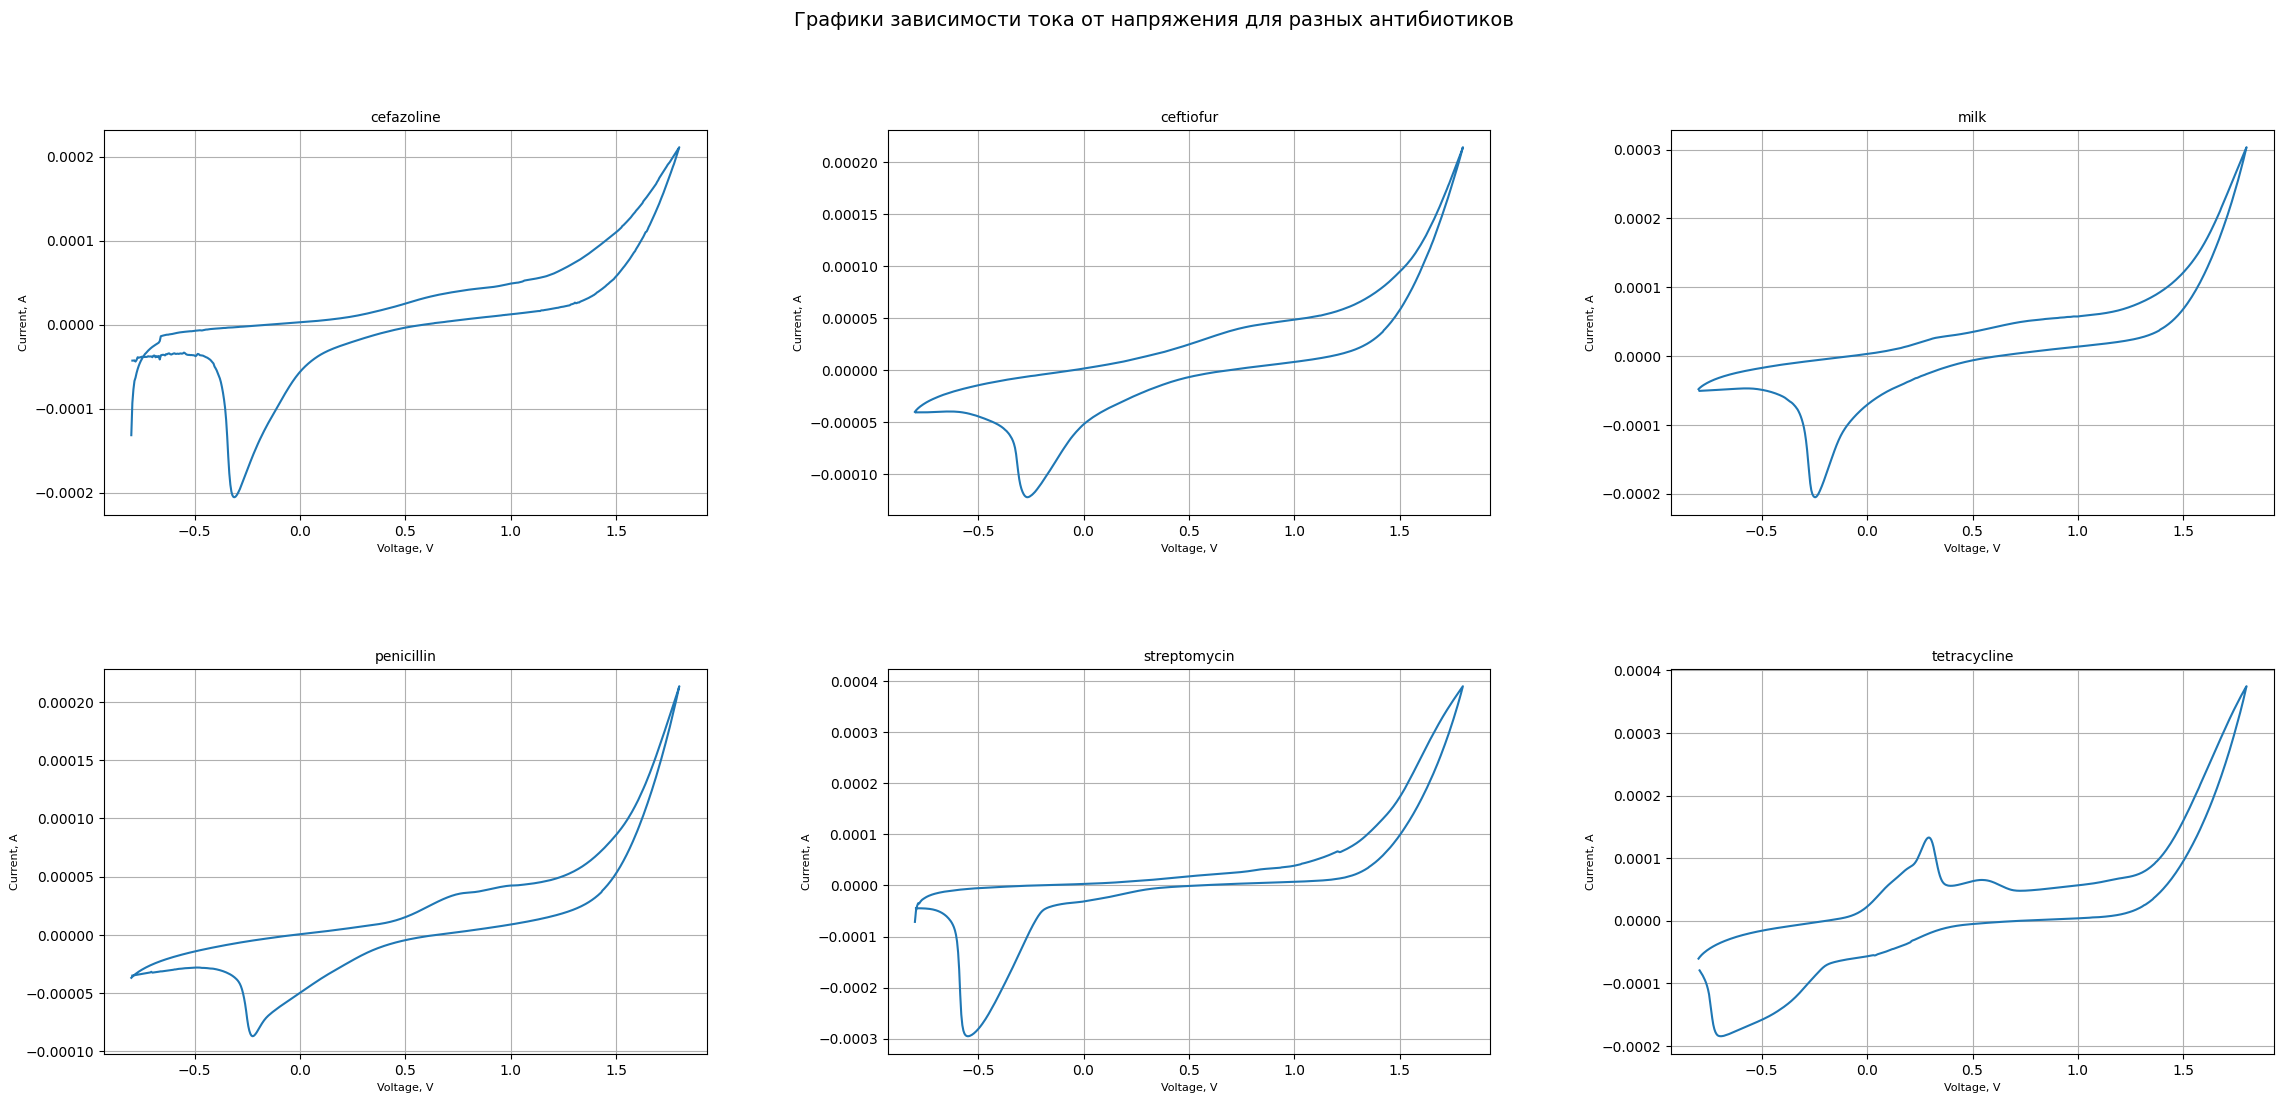

In [11]:
#Анализ данных
voltage_values = pd.read_csv(file_path)['Voltage, V'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(28, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

for idx, antibiotic_name in enumerate(data_frame['antibiotic'].unique()):
    antibiotic_data = data_frame[data_frame['antibiotic'] == antibiotic_name].iloc[0]
    current_values = antibiotic_data.iloc[:-2].astype(float).values
    ax = axes[idx // 3, idx % 3]
    ax.plot(voltage_values, current_values)
    ax.set_title(antibiotic_name, fontsize=10)
    ax.set_xlabel('Voltage, V', fontsize=8)
    ax.set_ylabel('Current, A', fontsize=8)
    ax.grid(True)
plt.suptitle('Графики зависимости тока от напряжения для разных антибиотиков', fontsize=14)
plt.show()

Logistic Regression:
  Accuracy: 0.8659
  Recall: 0.9955
  F1 Score: 0.9221
  AUC: 0.9306

k-Nearest Neighbors:
  Accuracy: 0.9239
  Recall: 0.9591
  F1 Score: 0.9526
  AUC: 0.9515

Random Forest:
  Accuracy: 0.9638
  Recall: 0.9727
  F1 Score: 0.9772
  AUC: 0.9953

Support Vector Machine:
  Accuracy: 0.8696
  Recall: 0.9591
  F1 Score: 0.9214
  AUC: 0.9267

Gradient Boosting:
  Accuracy: 0.9529
  Recall: 0.9636
  F1 Score: 0.9703
  AUC: 0.9933

Лучшая модель: Random Forest


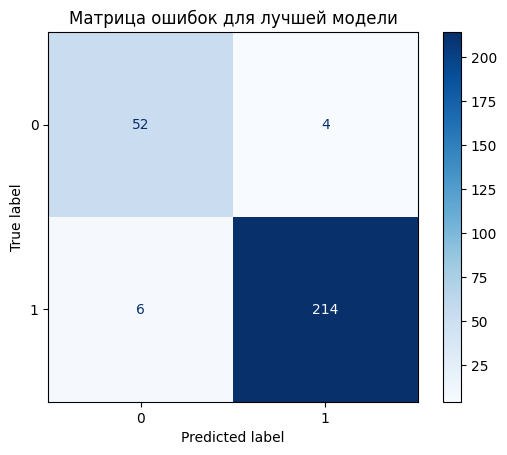

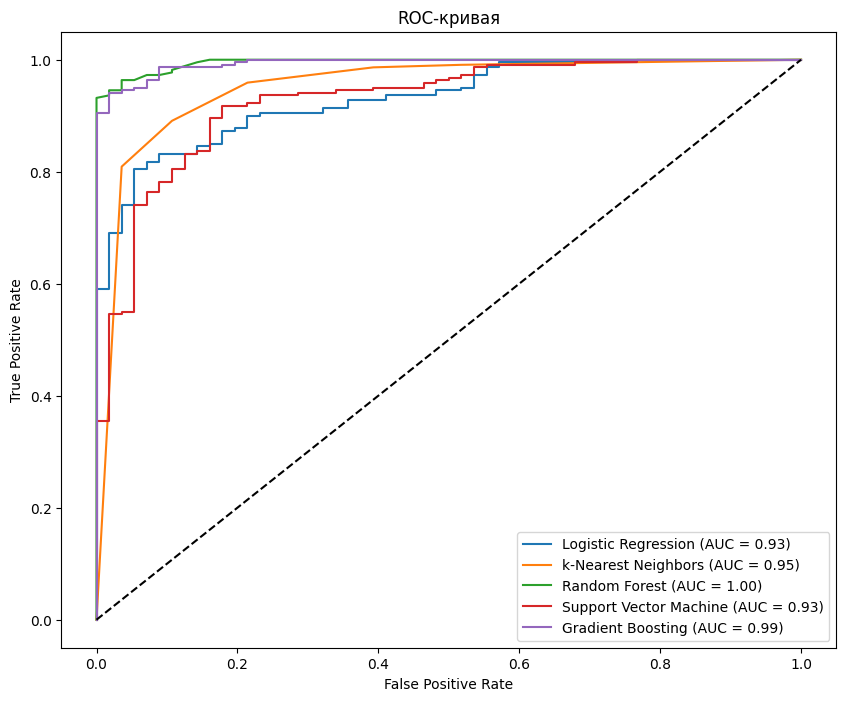

In [12]:
#Обучение моделей бинарной классификации
#Разделение собранных данных на признаки и целевую переменную
X = data_frame.drop(columns=['antibiotic', 'concentration'])
y = data_frame['antibiotic'].apply(lambda x: 0 if x=='milk' else 1).to_numpy()
#Нормализация признаков
norma = Normalizer()
X_normal = norma.fit_transform(X)
#Разделение данные на обучающую и тестовую выборки (80% для обучения, 20% для тестирования)
X_train, X_test, y_train, y_test = train_test_split(X_normal, y, test_size=0.2)
#Обучение и оценка моделей: Логистическая регрессия, k-ближайших соседей, Случайный лес, метод опорных векторов и градиентный бустинг
models = {
    "Logistic Regression": LogisticRegression(),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "Gradient Boosting": GradientBoostingClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else [0] * len(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    results[name] = {
        "Accuracy": accuracy,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc
    }
    
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  AUC: {auc:.4f}")
    print()

#Выбираем лучшую модель и строим ROC-кривую
best_model_name = max(results, key=lambda x: results[x]["AUC"])
best_model = models[best_model_name]
print(f"Лучшая модель: {best_model_name}")
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок для лучшей модели")
plt.show()


plt.figure(figsize=(10, 8))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Logistic Regression:
  Accuracy: 0.4638
  Recall: 0.4638
  F1 Score: 0.4106
  AUC: 0.8353

k-Nearest Neighbors:
  Accuracy: 0.7029
  Recall: 0.7029
  F1 Score: 0.7032
  AUC: 0.9285

Random Forest:
  Accuracy: 0.8986
  Recall: 0.8986
  F1 Score: 0.8984
  AUC: 0.9891

Support Vector Machine:
  Accuracy: 0.5688
  Recall: 0.5688
  F1 Score: 0.5251
  AUC: 0.9024

Gradient Boosting:
  Accuracy: 0.8696
  Recall: 0.8696
  F1 Score: 0.8700
  AUC: 0.9844

Лучшая модель: Random Forest


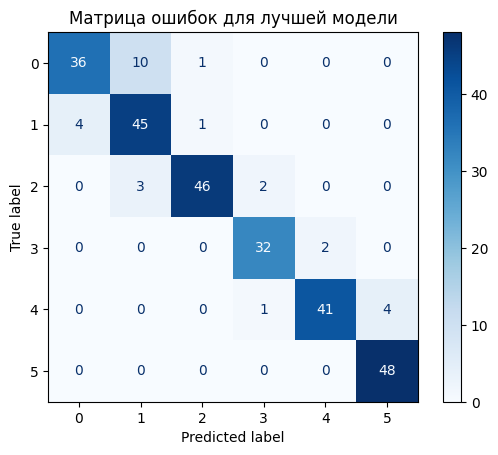

In [14]:
#Обучение моделей классификации на много классов
#Разделение собранных данных на признаки и целевую переменную
X = data_frame.drop(columns=['antibiotic', 'concentration'])
y = data_frame['antibiotic']
#Закодируем значения названий антибиотиков
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
#Нормализация признаков
norma = Normalizer()
X_normal = norma.fit_transform(X)
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_normal, y_encoded, test_size=0.2)
#Обучение и оценка моделей: Логистическая регрессия, k-ближайших соседей, Случайный лес, метод опорных векторов и градиентный бустинг
models = {
    "Logistic Regression": OneVsRestClassifier(LogisticRegression()),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": OneVsRestClassifier(SVC(probability=True)),
    "Gradient Boosting": GradientBoostingClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
    
    results[name] = {
        "Accuracy": accuracy,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc
    }
    
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  AUC: {auc:.4f}")
    print()
    
best_model_name = max(results, key=lambda x: results[x]["AUC"])
best_model = models[best_model_name]
print(f"Лучшая модель: {best_model_name}")

# Матрица ошибок для лучшей модели
y_pred_best = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_best)
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок для лучшей модели")
plt.show()